In [1]:
#Import des biblothèques utiles

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.linalg as la
from time import process_time
from Parameters import *
from Hydrogen import *
from Field import *

## Présentation de la méthode des éléments finis pour TDSE


We will apply the Crank-Nicolson (CN) scheme to integrate numerically Eq. 1 in one space dimension with Neumann boundary conditions.

$$i \frac{\partial \psi}{\partial t} = -\frac{1}{2} \frac{\partial^2 \psi}{\partial x^2} + V(x) \psi - x E(t) \psi, \qquad (Eq. 1)$$



# Finite Difference Methods

The above Schrödinger equation describes the time evolution of the variable $\psi(x,t)$ in one space dimension.

To approximate $\psi(x,t)$ numerically, we discretize the coordinate system with a two-dimensional regular grid.

Let us discretize both time and space:
$$t_n = n \Delta t, \quad n = 0, \dots, N - 1,$$
$$x_j = j \Delta x, \quad j = 0, \dots, J - 1,$$

where $N$ and $J$ are the number of discrete time and space points, respectively, and $Δt$ and $Δx$ are the time and space steps:
$$Δt = T / N, \quad Δx = L / J,$$

where $T$ is the final integration time.

Our goal is to approximate the unknown analytic solution $\psi(x,t)$ at discrete grid points, using the notation:
$$\Psi^n_j = \psi(jΔx, nΔt) \approx \psi(jΔx, nΔt).$$

# The Crank-Nicolson Stencil

To approximate the time derivative at grid point $(j,n)$, we use:
$$ \left. \frac{\partial \psi}{\partial t} \right|_{x = jΔx, t = nΔt} \approx \frac{\Psi^{n+1}_j - \Psi^n_j}{Δt}.$$

The spatial part of the Crank-Nicolson stencil for the Schrödinger equation ($i \psi_t = -\frac{1}{2} \psi_{xx} + V(x) \psi - x E(t) \psi$) approximates the Laplacian and potential operators as follows:
$$-\frac{1}{2} \left. \frac{\partial^2 \psi}{\partial x^2} \right|_{x = jΔx, t = nΔt} \approx \frac{-1}{4Δx^2} \left( \Psi^n_{j+1} - 2 \Psi^n_j + \Psi^n_{j-1} + \Psi^{n+1}_{j+1} - 2 \Psi^{n+1}_j + \Psi^{n+1}_{j-1} \right),$$


Applying this stencil to the grid point $(j,n)$ gives:
$$i\frac{\Psi^{n+1}_j - \Psi^n_j}{Δt} = \frac{-1}{4Δx^2} (\Psi^n_{j+1} - 2 \Psi^n_j + \Psi^n_{j-1} + \Psi^{n+1}_{j+1} - 2 \Psi^{n+1}_j + \Psi^{n+1}_{j-1}) + \frac{V(x_j)}{2} (\Psi^n_j + \Psi^{n+1}_j) - \frac{x_j E(nΔt)}{2} (\Psi^n_j + \Psi^{n+1}_j).$$



In [24]:
class CrankNicolson:
    
    def set_grid(self, x_min, x_max, n_x, t_min, t_max, n_t):

        self.x_min, self.x_max, self.n_x = x_min, x_max, n_x
        self.t_min, self.t_max, self.n_t = t_min, t_max, n_t
        self.x_pts, self.delta_x = np.linspace(x_min, x_max, n_x, retstep=True, endpoint=False)
        self.t_pts, self.delta_t = np.linspace(t_min, t_max, n_t, retstep=True, endpoint=False)
        
    def set_parameter(self,f):
        
        self.f = f
    
    def _make_tridiag(self, sig, n, data_type):
        
        M = np.diagflat(np.full(n, (1+2*sig), dtype=data_type)) +\
            np.diagflat(np.full(n-1, (-sig), dtype=data_type), 1) +\
            np.diagflat(np.full(n-1, (-sig), dtype=data_type), -1)
        
        return M
    
    def solve(self, psi_init):
        
        sig = (1j*self.delta_t)/(4*(self.delta_x)**2)
        data_type = type(psi_init[0]*sig)
        
        self.psi_matrix = np.zeros([self.n_t, self.n_x],dtype=data_type)
        
        A = self._make_tridiag(sig, self.n_x,data_type)
        B = self._make_tridiag(-sig, self.n_x, data_type)
        
        for i in [0,1]:
            A[1,-i] = 1.0
            A[2*i,1-3*i] = 0.0
            B[-i,-i] = 0.0
            B[-i,1-3*i] = 0.0
        
        psi = psi_init
        
        for k in range(self.n_t):
            t = k*self.delta_t
            self.psi_matrix[k,:] = psi
            fpsi = self.f(psi,t)
            if k==0: fpsi_old = fpsi
            psi = la.solve(A, B.dot(psi) - 1j* self.delta_t * (1.5 * fpsi - 0.5 * fpsi_old))
            fpsi_old = fpsi
        
    def get_final_psi(self):
        return self.psi_matrix[-1,:].copy()
    
           

        

In [34]:
## Test pour un simple Pulse

#Création du solveur
crank = CrankNicolson()

param_single_pulse = pars_YanPengPhysRevA_78_033821()[0]
#Def du champ laser simple
Field_single_pulse = Field.Pulse(param_single_pulse)
def Field_test(t):
    return Field_single_pulse(t)

#Def du potentiel 
atom = Hydrogen() 
def Potentiel_test(x):
    return atom.soft_core_potential(x)

# Those will not change
l = ((1/(2*Field_single_pulse.w))**2)*0.5*Field_single_pulse.a
x_min, x_max, nx = -l, l, 600
t_min, t_max, nt = 0, 1000., 1000

#Paramétrisation du solveur
crank.set_grid(x_min, x_max, nx, t_min, t_max, nt)
crank.set_parameter(f)

X = crank.x_pts
#Def de f
def f(u,t):
    return Potentiel_test(X)*u - X*u*Field_test(t)

#Def de psi_init

psi_init = atom.ground_state_wavefunction(X)


In [28]:
t1 = process_time()
crank.solve(psi_init)
t2 = process_time()
print("time to advance %i steps with full (%i x %i) matrices :"%(nt,nx,nx), t2-t1, "s")

time to advance 1000 steps with full (600 x 600) matrices : 386.590276 s


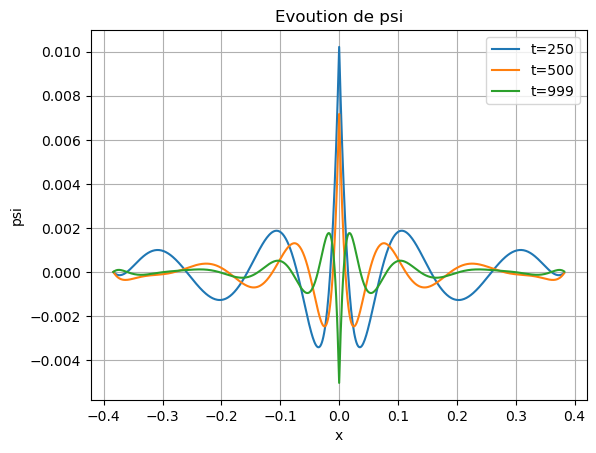

In [31]:
plt.figure()
plt.plot(X,crank.psi_matrix[0,:], label='t=0')
plt.plot(X,crank.psi_matrix[250,:], label='t=250')
plt.plot(X,crank.psi_matrix[500,:], label='t=500')
plt.plot(X,crank.psi_matrix[999,:], label='t=999')
plt.xlabel('x')
plt.ylabel('psi')
plt.grid()
plt.legend()
plt.title('Evoution de psi')
plt.show()

/Users/arthurgontier/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


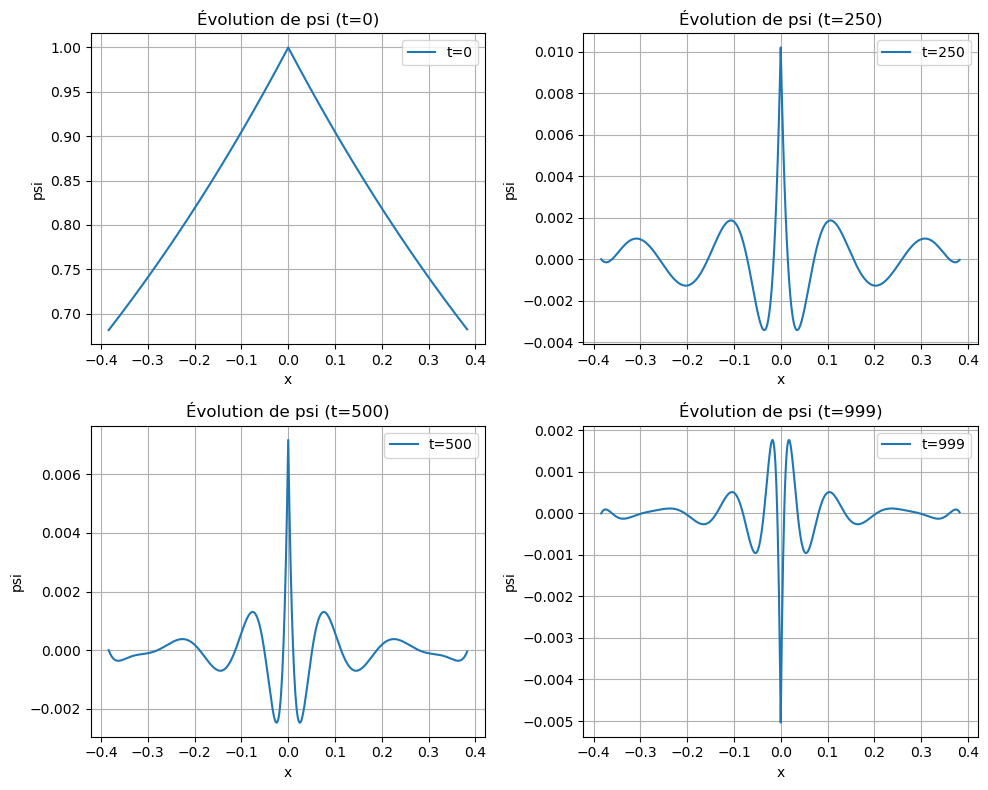

In [32]:
import matplotlib.pyplot as plt

# Créer une figure avec une disposition de 2 lignes et 2 colonnes
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Liste des temps et des indices correspondants
times = [0, 250, 500, 999]
labels = ['t=0', 't=250', 't=500', 't=999']

# Parcourir chaque sous-graphe
for ax, t, label in zip(axs.flat, times, labels):
    ax.plot(X, crank.psi_matrix[t, :], label=label)
    ax.set_xlabel('x')
    ax.set_ylabel('psi')
    ax.set_title(f'Évolution de psi ({label})')
    ax.grid()
    ax.legend()

# Ajuster la disposition
plt.tight_layout()
plt.show()
